# Lab 6. Data Modeling II - Part 2:  
## Decision Trees & Random Forest


In [1]:
######################################################################

### Lab Assignment 6.4

In this lab, you'll get started with decision trees by revisiting UCI's [wheat-seeds dataset](https://archive.ics.uci.edu/ml/datasets/seeds), so you can benchmark how long it takes to train and predict with decision trees relative to the speed of KNeighbors and SVC, as well as compare the decision boundary plots produced by it.

1. No starter code this time. Instead, take your completed Module6/<b>assignment1.py</b> and modify it by adding in a <b>Decision Tree Classifier</b>, setting its max_depth to 9, and random_state=2, but not altering any other setting.
2. Make sure you add in the benchmark and drawPlots call for our new classifier as well.
3. Answer the questions.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%pylab inline 
import pandas as pd
import numpy as np 
import time

Populating the interactive namespace from numpy and matplotlib


In [19]:
# Parameters.
C = 1
kernel = 'linear'
iterations = 5000  

FAST_DRAW = True

In [4]:
# Load up the wheat dataset into dataframe 'X'
X = pd.read_csv('Module6/Datasets/wheat.data', index_col=0)
X.head()

,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
id,,,,,,,,
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,kama


In [5]:
X[X.isnull().any(axis=1)]

,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
id,,,,,,,,
7,14.11,14.10,0.8911,5.4200,3.302,2.700,NaN,canadian
35,16.12,15.00,NaN,0.9000,NaN,5.709,3.485,canadian
60,11.42,12.86,0.8683,5.0080,2.850,2.700,NaN,canadian
135,15.38,14.66,0.8990,5.4770,3.465,3.600,NaN,canadian
169,11.24,13.00,NaN,0.8359,5.090,2.715,3.521,canadian
170,11.02,13.00,NaN,0.8189,5.325,2.701,6.735,canadian
201,12.67,13.32,0.8977,4.9840,3.135,2.300,NaN,canadian


In [9]:
X.isnull().sum()

area           0
perimeter      0
compactness    3
length         0
width          1
asymmetry      0
groove         4
wheat_type     0
dtype: int64

In [11]:
X_dr = X.copy()
X_dr = X_dr.dropna(axis=0)
X_dr.isnull().sum()

area           0
perimeter      0
compactness    0
length         0
width          0
asymmetry      0
groove         0
wheat_type     0
dtype: int64

In [16]:
y = X_dr.wheat_type.copy()
y = y.astype("category").cat.codes

print y.unique()
print
print y.head()

[1 0 2]

id
0    1
1    1
2    1
3    1
4    1
dtype: int8


In [17]:
X_dr.drop(labels=['wheat_type'], inplace=True, axis=1)
X_dr.head()

,area,perimeter,compactness,length,width,asymmetry,groove
id,,,,,,,
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dr, y, test_size=0.3, random_state=7)

In [20]:
# Create an SVC classifier named svc
# Use a linear kernel, and set the C value to C
from sklearn.svm import SVC
svc = SVC(C=C, kernel=kernel)

In [21]:
# Create an KNeighbors classifier named knn
# Set the neighbor count to 5
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [22]:
# Create a Decision Tree classifier setting its max_depth to 9, 
# and random_state=2, but not altering any other setting.
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth = 9, random_state = 2)

In [29]:
def drawPlots(model, wintitle='Figure 1'):
    # INFO: A convenience function for you
    # You can use this to break any higher-dimensional space down
    # And view cross sections of it.

    # If this line throws an error, use plt.style.use('ggplot') instead
    mpl.style.use('ggplot') # Look Pretty

    padding = 3
    resolution = 0.5
    max_2d_score = 0

    y_colors = ['#ff0000', '#00ff00', '#0000ff']
    my_cmap = mpl.colors.ListedColormap(['#ffaaaa', '#aaffaa', '#aaaaff'])
    colors = [y_colors[i] for i in y_train]
    num_columns = len(X_train.columns)

    #fig = plt.figure(figsize(9,9))
    fig = plt.figure()
    fig.canvas.set_window_title(wintitle)

    cnt = 0
    for col in range(num_columns):
        for row in range(num_columns):
            # Easy out
            if FAST_DRAW and col > row:
                cnt += 1
                continue

            ax = plt.subplot(num_columns, num_columns, cnt + 1)
            plt.xticks(())
            plt.yticks(())

            # Intersection:
            if col == row:
                plt.text(0.5, 0.5, X_train.columns[row], verticalalignment='center', horizontalalignment='center', fontsize=12)
                cnt += 1
                continue


            # Only select two features to display, then train the model
            X_train_bag = X_train.ix[:, [row,col]]
            X_test_bag = X_test.ix[:, [row,col]]
            model.fit(X_train_bag, y_train)

            # Create a mesh to plot in
            x_min, x_max = X_train_bag.ix[:, 0].min() - padding, X_train_bag.ix[:, 0].max() + padding
            y_min, y_max = X_train_bag.ix[:, 1].min() - padding, X_train_bag.ix[:, 1].max() + padding
            xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                                 np.arange(y_min, y_max, resolution))

            # Plot Boundaries
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())

            # Prepare the contour
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=my_cmap, alpha=0.8)
            plt.scatter(X_train_bag.ix[:, 0], X_train_bag.ix[:, 1], c=colors, alpha=0.5)


            score = round(model.score(X_test_bag, y_test) * 100, 3)
            plt.text(0.5, 0, "Score: {0}".format(score), transform = ax.transAxes, horizontalalignment='center', fontsize=8)
            max_2d_score = score if score > max_2d_score else max_2d_score

            cnt += 1

    print "Max 2D Score: ", max_2d_score
    fig.set_tight_layout(True)

In [26]:
def benchmark(model, wintitle='Figure 1'):
    print '\n' + wintitle + ' Results'
    s = time.time()
    for i in range(iterations):
        # train the classifier on the training data / labels:
        res = model.fit(X_train, y_train)
    print "{0} Iterations Training Time: ".format(iterations), time.time() - s


    s = time.time()
    for i in range(iterations):
        # score the classifier on the testing data / labels:
        score = res.score(X_test, y_test)
        
    print "{0} Iterations Scoring Time: ".format(iterations), time.time() - s
    print "High-Dimensionality Score: ", round((score*100), 3)

In [27]:
benchmark(knn, 'KNeighbors')
benchmark(svc, 'SVC')
benchmark(dtree, 'Decision Trees')


KNeighbors Results
5000 Iterations Training Time:  2.9346909523
5000 Iterations Scoring Time:  6.48684811592
High-Dimensionality Score:  83.607

SVC Results
5000 Iterations Training Time:  6.30502796173
5000 Iterations Scoring Time:  2.98242497444
High-Dimensionality Score:  86.885

Decision Trees Results
5000 Iterations Training Time:  4.06538891792
5000 Iterations Scoring Time:  2.30657410622
High-Dimensionality Score:  91.803


Max 2D Score:  90.164


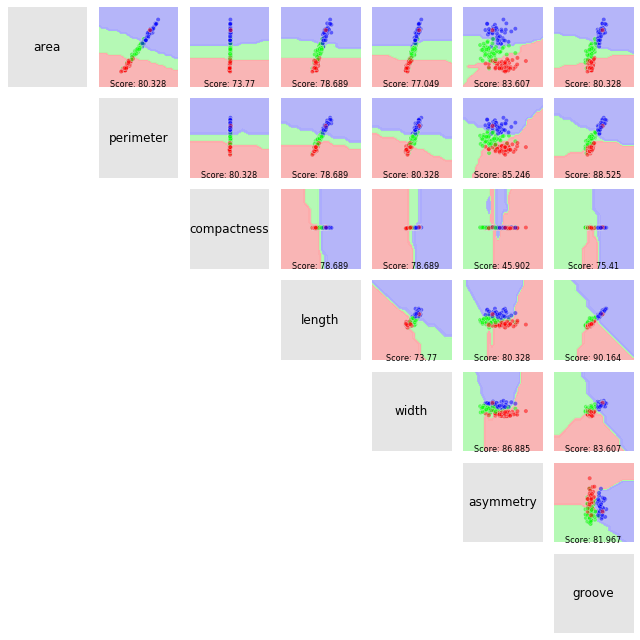

In [30]:
drawPlots(knn, 'KNeighbors')
plt.show()

Max 2D Score:  93.443


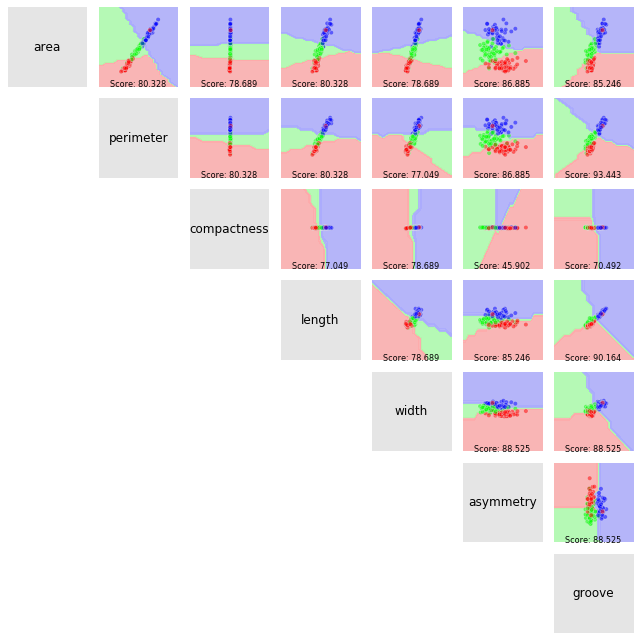

In [31]:
drawPlots(svc, 'SVC')

Max 2D Score:  90.164


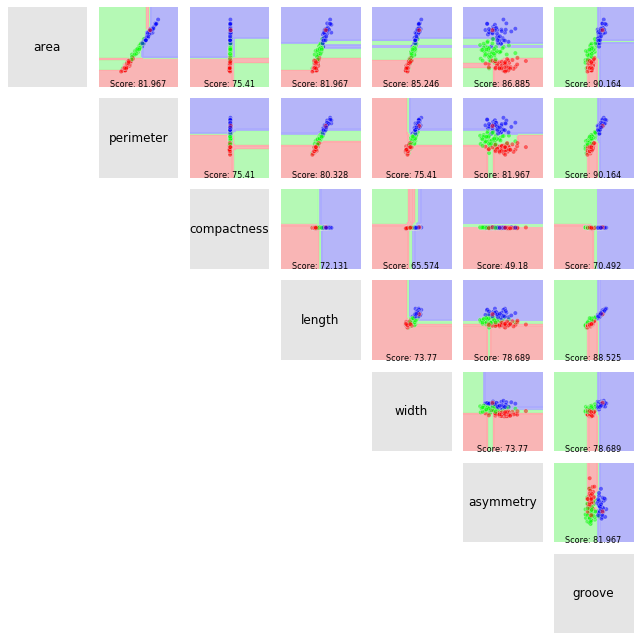

In [32]:
drawPlots(dtree, 'Decision Trees')

In [ ]:
'''
KNN results
- High-Dimensionality Score:  83.607
- Max 2D score: 90.164

SVC Results 
- High-Dimensionality Score:  86.885
- Max 2D score: 93.443

Decision Trees Results
- High-Dimensionality Score:  91.803
- Max 2D score: 90.164
'''

##### Lab Question 6.4.1 (1 point possible)

To make sure everyone is on the same page, irrespective of the parameters you had on assignment1.py, go ahead and make the following changes:

- C = 1
- kernel = 'linear'
- iterations = 5000
- n_neighbors = 5
- max_depth = 9

Which of the following statements is true?

- (a) DTrees beat SVC's score in the original, high-D feature space; but SVC has the highest 2D score
- (b) KNeighbors has the highest 2D score; but no one beats SVC's score in the original, high-D feature space
- (c) KNeighbors and DTrees both tie in their scoring of accuracy in the original, high-D feature space
- (d) DTrees are the worst in the original, high-D feature space; but have the best max 2D score

<b>* My answer</b>: (a) (<== <b>Correct!</b>)

<b>* Explanation</b>: 

KNeighbors Results
- 5000 Iterations Training Time: 1.95918607712
- 5000 Iterations Scoring Time: 3.89638900757
- High-Dimensionality Score: 83.607
- Max 2D Score: 90.164

SVC Results
- 5000 Iterations Training Time: 4.01298189163
- 5000 Iterations Scoring Time: 1.68990087509
- High-Dimensionality Score: 86.885
- Max 2D Score: 93.443

DTree Results
- 5000 Iterations Training Time: 2.55399107933
- 5000 Iterations Scoring Time: 1.31068205833
- High-Dimensionality Score: 91.803
- Max 2D Score: 90.164

##### Lab Question 6.4.2 (1 point possible)

Keep dropping the max_depth of the decision tree down until it's high-dimensionality score is less than KNeighbors, and then stop.

What is the max_depth value that you hit?

- (a) Five
- (b) Four
- (c) Three
- (b) Two
- (a) One

In [44]:
def find_beatknn_max_depth(model, knn_score, depth):
    for i in range(iterations):
        res = model.fit(X_train, y_train)
        score = round(model.score(X_test, y_test) * 100, 3)
        if(score < int(knn_score)):
            print "decision tree score = {0}, < knn score ({1}), at depth {2}".format(score, knn_score, depth)
            break

In [45]:
# Keep dropping the max_depth of the decision tree down 
# until its high-dimensionality score is less than KNeighbors, and then stop.
# What is the max_depth value that you hit?
max_knn_hi_dim_score = 83.607

for d in arange(9,0,-1):
    dtree = tree.DecisionTreeClassifier(max_depth = d, random_state = 2)
    find_beatknn_max_depth(dtree, max_knn_hi_dim_score, d)

decision tree score = 68.852, < knn score (83.607), at depth 1



<b>* My answer</b>: (e) One (<== <b>Correct!</b>)

<b>* Explanation</b>: 

Decision trees are highly optimal. On this specific dataset, even with as little as two splits, they still out-do KNeighbors, and even fair well against SVC.
max_depth = 1

KNeighbors Results
- 5000 Iterations Training Time: 1.9534471035
- 5000 Iterations Scoring Time: 3.8806810379
- High-Dimensionality Score: 83.607
- Max 2D Score: 90.164

SVC Results
- 5000 Iterations Training Time: 3.85418701172
- 5000 Iterations Scoring Time: 1.6913061142
- High-Dimensionality Score: 86.885
- Max 2D Score: 93.443

DTree Results
- 5000 Iterations Training Time: 1.70960593224
- 5000 Iterations Scoring Time: 1.32432198524
- High-Dimensionality Score: 68.852
- Max 2D Score: 68.852

In [2]:
######################################################################

### Lab Assignment 6.5

Mycology is a branch of biology that generally deals with the study of fungi and mushrooms, and particularly their genetic and biochemical make-up, and their use to humans. Throughout history, fungi have been used for tinder, medicine, and food. For hundreds of years, specific mushrooms have been used as folk medicine in Russian, China, and Japan. Scientists elsewhere have also documented many medicinal uses of mushrooms as well, but not all mushrooms are beneficial--some are quite deadly.

![Mushroom](https://courses.edx.org/asset-v1:Microsoft+DAT210x+4T2016+type@asset+block@mushroom.jpeg 'Mushroom' )

In this lab, you're going to use decision trees to peruse The [Mushroom Data Set](https://archive.ics.uci.edu/ml/datasets/Mushroom), drawn from the Audobon Society Field Guide to North American Mushrooms (1981). The data set details mushrooms described in terms of many physical characteristics, such as cap size and stalk length, along with a classification of poisonous or edible.

As a standard disclaimer, if you eat a random mushroom you find, you are doing so at your own risk. While every effort has been made to ensure that the information contained with the data set is correct, please understand that no one associated with this course accepts any responsibility or liability for errors, omissions or representations, expressed or implied, contained therein, or that might arise from you mistakenly identifying a mushroom. Exercise due caution and just take this lab as informational purposes only.

1. First, visit the [data set's page](https://archive.ics.uci.edu/ml/datasets/Mushroom) and read through it carefully. Understand what they're saying about missing value representations, and header names, and where the classification column is located. Peek through the data values in a spreadsheet program or text editor and get comfortable with it.
2. Load up the started code in Module6/<b>assignment5.py</b>.
3. A copy of the dataset is included in Module6/Datasets/<b>agaricus-lepiota.data</b>.
4. You're going to need to review the decision tree code in the SciKit-Learn section of the Decision Tree section. It contains a few calls in there necessary for the completion of the assignment. If you're unable to install graphiz, use webgraphviz, or alternative complete the assignment by examining the attributes of your classifier.
5. Answer the questions.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%pylab inline 
import pandas as pd
import numpy as np 

Populating the interactive namespace from numpy and matplotlib


In [92]:
# Load up the mushroom dataset into dataframe 'X'
# Verify you did it properly.
# Indices shouldn't be doubled.
# Header information is on the dataset's website at the UCI ML Repo
# Check NA Encoding
X = pd.read_csv('Module6/Datasets/agaricus-lepiota.data', na_values= "?")
print X.head()

   p  x  s  n  t p.1  f  c n.1  k ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0  e  x  s  y  t   a  f  c   b  k ...   s  w   w   p   w  o   p   n   n  g
1  e  b  s  w  t   l  f  c   b  n ...   s  w   w   p   w  o   p   n   n  m
2  p  x  y  w  t   p  f  c   n  n ...   s  w   w   p   w  o   p   k   s  u
3  e  x  s  g  f   n  f  w   b  k ...   s  w   w   p   w  o   e   n   a  g
4  e  x  y  y  t   a  f  c   b  n ...   s  w   w   p   w  o   p   k   n  g

[5 rows x 23 columns]


* https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names

In [95]:
X.columns

Index([u'p', u'x', u's', u'n', u't', u'p.1', u'f', u'c', u'n.1', u'k', u'e',
       u'e.1', u's.1', u's.2', u'w', u'w.1', u'p.2', u'w.2', u'o', u'p.3',
       u'k.1', u's.3', u'u'],
      dtype='object')

In [96]:
X.columns = ['classes', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
print X.head()

  classes cap-shape cap-surface cap-color bruises? odor gill-attachment  \
0       e         x           s         y        t    a               f   
1       e         b           s         w        t    l               f   
2       p         x           y         w        t    p               f   
3       e         x           s         g        f    n               f   
4       e         x           y         y        t    a               f   

  gill-spacing gill-size gill-color   ...   stalk-surface-below-ring  \
0            c         b          k   ...                          s   
1            c         b          n   ...                          s   
2            c         n          n   ...                          s   
3            w         b          k   ...                          s   
4            c         b          n   ...                          s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                    

In [97]:
X.dtypes

classes                     object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises?                    object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [98]:
# INFO: An easy way to show which rows have nans in them
#print X[pd.isnull(X).any(axis=1)]
X.isnull().sum()  

classes                        0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [112]:
# TODO: Go ahead and drop any row with a nan
#
X_dr = X.copy()
print "Before drop NA: ", X_dr.shape

X_dr.dropna(axis = 0, inplace=True, how='any') 
print "After  drop NA: ",  X_dr.shape

# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html
# dropna parameters
# (a) how : {‘any’, ‘all’}
# - any : if any NA values are present, drop that label
# - all : if all values are NA, drop that label

# (b) inplace : boolean, default False
# - If True, do operation inplace and return None.

Before drop NA:  (8123, 23)
After  drop NA:  (5643, 23)


In [113]:
# TODO: Copy the labels out of the dset into variable 'y' then Remove
# them from X. Encode the labels, using the .map() trick we showed
# you in Module 5 -- canadian:0, kama:1, and rosa:2
y = X_dr.classes.copy()
print y.unique()

['e' 'p']


In [114]:
y = y.map({'e': 0, 'p': 1} )
print y.head()
print "\nShape of y: ",y.shape

0    0
1    0
2    1
3    0
4    0
Name: classes, dtype: int64

Shape of y:  (5643,)


In [115]:
X_dr.drop(labels=['classes'], inplace=True, axis=1)
print "Shape of X_dr: ", X_dr.shape

Shape of X_dr:  (5643, 22)


In [116]:
# TODO: Encode the entire dataset using dummies
#X_dr = pd.get_dummies(X_dr)
X_dr = pd.get_dummies(X_dr, columns = ['cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])

print "After dummies: ", X_dr.shape
X_dr.head()

After dummies:  (5643, 98)


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


In [117]:
# TODO: Split your data into test / train sets
# Your test size can be 30% with random_state 7
# Use variable names: X_train, X_test, y_train, y_test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dr, y, test_size=0.3, random_state=7)

len(X_train), len(X_test), len(y_train), len(y_test)

(3950, 1693, 3950, 1693)

In [118]:
# TODO: Create an DT classifier. No need to set any parameters
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [130]:
# TODO: train the classifier on the training data / labels:
# TODO: score the classifier on the testing data / labels:
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print "High-Dimensionality Score: ", round((score*100), 3)

High-Dimensionality Score:  100.0


* I initially thought it was overfitting because the score was 100. But the answer to the lab question 2 said that the correct score was 100.00. (So, 100 was the correct accuracy value)

In [120]:
# TODO: Use the code on the courses SciKit-Learn page to output a .DOT file
# Then render the .DOT to .PNGs. Ensure you have graphviz installed.
# If not, `brew install graphviz. If you can't, use: http://webgraphviz.com/
tree.export_graphviz(model.tree_, out_file = 'Module6/Datasets/tree.dot', feature_names = X_dr.columns)

In [2]:
from subprocess import call
call(['dot', '-T', 'png', 'tree.dot', '-o', 'tree.png'])

0

![TreeImg](Module6/Datasets/tree.png "tree")

##### Lab Question 6.5.1 (1 point possible)

What are the top two features you should consider when deciding if a mushroom is eadible or not?

- (a) Odor, and Gill Size
- (b) Stalk Color Below Ring, and Gill Color
- (c) Bruises?, and Cap Color
- (d) Population, and Cap Shape
- (e) Spore Print Color, and Veil Type

In [132]:
# From my previous ipython code
feature_importance = zip(X_train, model.feature_importances_)

dtype = [('feature', 'S10'), ('importance', 'float')] # S10: 10-character string
feature_importance = np.array(feature_importance, dtype = dtype)
my_feature_sort = np.sort(feature_importance, order='importance')[::-1]

print "Top 5 important features are: \n", my_feature_sort[0:5]

Top 5 important features are: 
[('spore-prin', 0.638489733424509) ('gill-size_', 0.16219328833575347)
 ('stalk-shap', 0.05831012530232848) ('ring-numbe', 0.05798943841994421)
 ('odor_n', 0.04893101530510457)]


<b>* My answer</b>: (a) (<== <b>Correct!</b>)

<b>* Explanation</b>: 
Once you build out the decision tree, the nodes closer to the top are the most important nodes.

##### Lab Question 6.5.2 (1 point possible)

Please enter a numeric value (e.g. 0, 1, 10.5, etc) which correctly answers the question(s) below:

- What was your decision tree's accuracy after testing it against the independent testing set? Enter it as printed in the lab

<b>* My answer</b>: 100 (<== <b>Correct!</b>)

<b>* Explanation</b>: 
This dataset was pretty easy for the tree to classify. You should have got a 100% score.

In [ ]:
######################################################################

### Lab Assignment 6.6

Human activity monitoring is a growing field within data science. It has practical use within the healthcare industry, particular with tracking the elderly to make sure they don't end up doing things which might cause them to hurt themselves. Governments are also very interested in it do that they can detect unusual crowd activities, perimeter breaches, or the identification of specific activities, such as loitering, littering, or fighting. Fitness apps also make use of activity monitoring to better estimate the amount of calories used by the body during a period of time.

In this lab, you will be training a random forest against a public domain Human Activity Dataset titled [Wearable Computing: Accelerometers' Data Classification of Body Postures and Movements](http://groupware.les.inf.puc-rio.br/har#dataset), containing 165,633, one of which is invalid. Within the dataset, there are five target activities:

* Sitting
* Sitting Down
* Standing
* Standing Up
* Walking

These activities were captured from four people wearing accelerometers mounted on their waist, left thigh, right arm, and right ankle. To get started:

1. Acquire the [DLA HAR  Dataset](http://groupware.les.inf.puc-rio.br/har#dataset) from their webpage. Be sure to get the <b>dataset-har-PUC-Rio-ugulino.zip</b> file and not the weight lifting one. That's a bonus dataset you can try fitting afterwards!
2. Open up the sample code located in Module6/<b>assignment6.py</b> and read through it.
3. Complete out all the requisite ToDo's as usual.
4. Finally, answer the following questions:

In [133]:
import pandas as pd
import time

In [134]:
# Grab the DLA HAR dataset from:
# http://groupware.les.inf.puc-rio.br/har
# http://groupware.les.inf.puc-rio.br/static/har/dataset-har-PUC-Rio-ugulino.zip

In [155]:
# TODO: Load up the dataset into dataframe 'X'
# Just for testing 
X = pd.read_csv('Module6/Datasets/dataset-har-PUC-Rio-ugulino.csv')
X.head()

user;gender;age;how_tall_in_meters;weight;body_mass_index;x1;y1;z1;x2;y2;z2;x3;y3;z3;x4;y4;z4;class
debora;Woman;46;1 62;75;28  6;-3;92;-63;-23;18;-19;5;104;-92;-150;-103;-14...                                                 
                  62;75;28  6;-3;94;-64;-21;18;-18;-14;104;-90;-149;-104;-...                                                 
                  62;75;28  6;-1;97;-61;-12;20;-15;-13;104;-90;-151;-104;-...                                                 
                  62;75;28  6;-2;96;-57;-15;21;-16;-13;104;-89;-153;-103;-...                                                 
                  62;75;28  6;-1;96;-61;-13;20;-15;-13;104;-89;-153;-104;-...

In [213]:
X = pd.read_csv('Module6/Datasets/dataset-har-PUC-Rio-ugulino.csv', sep=";", decimal=",")
X.head()

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
0,debora,Woman,46,1.62,75,28.6,-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147,sitting
1,debora,Woman,46,1.62,75,28.6,-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145,sitting
2,debora,Woman,46,1.62,75,28.6,-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144,sitting
3,debora,Woman,46,1.62,75,28.6,-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142,sitting
4,debora,Woman,46,1.62,75,28.6,-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143,sitting


In [214]:
X.describe()

,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4
count,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000
mean,38.265146,1.639712,70.819408,26.188522,-6.649327,88.293667,-93.164611,-87.827504,-52.065047,-175.055200,17.423515,104.517167,-93.881726,-167.641448,-92.625171
std,13.184091,0.052820,11.296527,2.995777,11.616238,23.895829,39.409423,169.435194,205.159763,192.816615,52.635388,54.155843,45.389646,38.311342,19.968610
min,28.000000,1.580000,55.000000,22.000000,-306.000000,-271.000000,-603.000000,-494.000000,-517.000000,-617.000000,-499.000000,-506.000000,-613.000000,-702.000000,-526.000000
25%,28.000000,1.580000,55.000000,22.000000,-12.000000,78.000000,-120.000000,-35.000000,-29.000000,-141.000000,9.000000,95.000000,-103.000000,-190.000000,-103.000000
50%,31.000000,1.620000,75.000000,28.400000,-6.000000,94.000000,-98.000000,-9.000000,27.000000,-118.000000,22.000000,107.000000,-90.000000,-168.000000,-91.000000
75%,46.000000,1.710000,83.000000,28.600000,0.000000,101.000000,-64.000000,4.000000,86.000000,-29.000000,34.000000,120.000000,-80.000000,-153.000000,-80.000000
max,75.000000,1.710000,83.000000,28.600000,509.000000,533.000000,411.000000,473.000000,295.000000,122.000000,507.000000,517.000000,410.000000,-13.000000,86.000000


In [215]:
X.dtypes

user                   object
gender                 object
age                     int64
how_tall_in_meters    float64
weight                  int64
body_mass_index       float64
x1                      int64
y1                      int64
z1                      int64
x2                      int64
y2                      int64
z2                      int64
x3                      int64
y3                      int64
z3                      int64
x4                      int64
y4                      int64
z4                     object
class                  object
dtype: object

In [216]:
X.isnull().sum()

user                  0
gender                0
age                   0
how_tall_in_meters    0
weight                0
body_mass_index       0
x1                    0
y1                    0
z1                    0
x2                    0
y2                    0
z2                    0
x3                    0
y3                    0
z3                    0
x4                    0
y4                    0
z4                    0
class                 0
dtype: int64

In [218]:
X.z4.unique()

array([-147, -145, -144, -142, -143, -146, -138, -139, -141, -133, -134,
       -135, -140, -137, -148, -151, -149, -150, -152, -156, -157, -155,
       -154, -153, -158, -159, -162, -163, -161, -160, -164, -165, -136,
       -126, -125, -122, -132, -167, -170, -169, -175, -173, -166, -168,
       -171, -172, -174, -179, -177, -176, -127, -131, -184, -181, -178,
       -180, -106, -114, -116, -115, -89, -79, -93, -78, -128, -109, -113,
       -119, -102, -111, -103, -130, -129, -182, -121, -186, -183, -187,
       -190, -188, -189, -185, -192, -191, -193, -194, -197, -196, -201,
       -251, -195, -199, -198, -123, -124, -112, -118, -120, -99, -95, -68,
       -110, -117, -96, -100, -105, -92, -88, -107, -213, -108, -104, -98,
       -94, -91, -97, -69, -101, -86, -82, -66, -77, -90, -56, -74, -83,
       -81, -219, -200, '-158', '-165', '-157', '-160', '-161', '-155',
       '-162', '-156', '-159', '-163', '-168', '-170', '-166', '-172',
       '-177', '-171', '-169', '-173', '-167', 

In [219]:
# TODO: Encode the gender column, 0 as male, 1 as female
X.gender.unique()

array(['Woman', 'Man'], dtype=object)

In [220]:
X.gender = X.gender.map({'Man': 0, 'Woman': 1})
X.gender.unique()

array([1, 0])

In [221]:
# INFO: Check data types
print X.dtypes

user                   object
gender                  int64
age                     int64
how_tall_in_meters    float64
weight                  int64
body_mass_index       float64
x1                      int64
y1                      int64
z1                      int64
x2                      int64
y2                      int64
z2                      int64
x3                      int64
y3                      int64
z3                      int64
x4                      int64
y4                      int64
z4                     object
class                  object
dtype: object


In [222]:
# TODO: Convert any column that needs to be converted into numeric
# use errors='raise'. This will alert you if something ends up being
# problematic
X.z4 = pd.to_numeric(X.z4, errors='raise')

ValueError: Unable to parse string

In [224]:
X[ X.z4 == '-14420-11-2011 04:50:23.713']

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
122076,jose_carlos,0,75,1.67,67,24,-8,101,-120,-13,91,-101,17,123,-108,-207,-82,-14420-11-2011 04:50:23.713,standingup


In [225]:
X.z4 = pd.to_numeric(X.z4, errors = 'coerce')

In [226]:
# INFO: If you find any problematic records, drop them before calling the
# to_numeric methods above...
X.isnull().sum()

user                  0
gender                0
age                   0
how_tall_in_meters    0
weight                0
body_mass_index       0
x1                    0
y1                    0
z1                    0
x2                    0
y2                    0
z2                    0
x3                    0
y3                    0
z3                    0
x4                    0
y4                    0
z4                    1
class                 0
dtype: int64

In [227]:
X.dropna(inplace=True, how='any', axis=0)

In [228]:
# TODO: Encode your 'y' value as a dummies version of your dataset's "class" column
y = X['class'].copy()
y = pd.get_dummies(y)
y.head()

,sitting,sittingdown,standing,standingup,walking
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [229]:
# TODO: Get rid of the user and class columns
X.drop(labels=['user', 'class'], inplace=True, axis=1)
X.head()

,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
0,1,46,1.62,75,28.6,-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147
1,1,46,1.62,75,28.6,-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145
2,1,46,1.62,75,28.6,-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144
3,1,46,1.62,75,28.6,-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142
4,1,46,1.62,75,28.6,-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143


In [230]:
X.describe()

,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
count,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000
mean,0.612044,38.264925,1.639712,70.819431,26.188535,-6.649319,88.293591,-93.164449,-87.827956,-52.065911,-175.055647,17.423517,104.517056,-93.881641,-167.641211,-92.625235,-159.650985
std,0.487286,13.183821,0.052820,11.296557,2.995781,11.616273,23.895881,39.409487,169.435606,205.160081,192.817111,52.635546,54.155987,45.389770,38.311336,19.968653,13.221020
min,0.000000,28.000000,1.580000,55.000000,22.000000,-306.000000,-271.000000,-603.000000,-494.000000,-517.000000,-617.000000,-499.000000,-506.000000,-613.000000,-702.000000,-526.000000,-537.000000
25%,0.000000,28.000000,1.580000,55.000000,22.000000,-12.000000,78.000000,-120.000000,-35.000000,-29.000000,-141.000000,9.000000,95.000000,-103.000000,-190.000000,-103.000000,-167.000000
50%,1.000000,31.000000,1.620000,75.000000,28.400000,-6.000000,94.000000,-98.000000,-9.000000,27.000000,-118.000000,22.000000,107.000000,-90.000000,-168.000000,-91.000000,-160.000000
75%,1.000000,46.000000,1.710000,83.000000,28.600000,0.000000,101.000000,-64.000000,4.000000,86.000000,-29.000000,34.000000,120.000000,-80.000000,-153.000000,-80.000000,-153.000000
max,1.000000,75.000000,1.710000,83.000000,28.600000,509.000000,533.000000,411.000000,473.000000,295.000000,122.000000,507.000000,517.000000,410.000000,-13.000000,86.000000,-43.000000


In [231]:
# INFO: An easy way to show which rows have nans in them
X[pd.isnull(X).any(axis=1)]

,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4


In [232]:
# TODO: Create an RForest classifier 'model' and set n_estimators=30,
# the max_depth to 10, and oob_score=True, and random_state=0
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=30, max_depth=10, oob_score=True, random_state=0)

In [233]:
# TODO: Split your data into test / train sets
# Your test size can be 30% with random_state 7
# Use variable names: 
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [234]:
print "Fitting..."
s = time.time()

# TODO: train your model on your training set
model.fit(X_train, y_train)

print "Fitting completed in: ", time.time() - s

Fitting...
Fitting completed in:  22.183618784


In [235]:
# INFO: Display the OOB Score of your data
score = model.oob_score_
print "OOB Score: ", round((score*100), 3)

OOB Score:  98.744


In [236]:
print "Scoring..."
s = time.time()

# TODO: score your model on your test set
score = model.score(X_test, y_test)
print "Score: ", round((score*100), 3)
print "Scoring completed in: ", time.time() - s

Scoring...
Score:  95.687
Scoring completed in:  1.87501502037


In [238]:
# TODO: Answer the lab questions, then come back to experiment more

##### Lab Question 6.6. (1 point possible)
Please enter a numeric value (e.g. 0, 1, 10.5, etc) which correctly answers the question(s) below:

Whichever score ended up being the lesser value, either the OOB score or the model's accuracy score, enter that figure below:

<b>* My answer</b>: 95.687 (<== <b>Correct!</b>)

<b>* Explanation</b>: 
95.687

In [247]:
# TODO: Try playing around with the gender column
# Encode it as Male:1, Female:0
# Try encoding it to pandas dummies
# Also try dropping it. See how it affects the score
# This will be a key on how features affect your overall scoring
# and why it's important to choose good ones.

# > Encoding gender was already done. So, I'll drop the gender column
X = pd.read_csv('Module6/Datasets/dataset-har-PUC-Rio-ugulino.csv', sep=";", decimal=",")

X.columns

Index([u'user', u'gender', u'age', u'how_tall_in_meters', u'weight',
       u'body_mass_index', u'x1', u'y1', u'z1', u'x2', u'y2', u'z2', u'x3',
       u'y3', u'z3', u'x4', u'y4', u'z4', u'class'],
      dtype='object')

In [248]:
X.drop(labels=['gender'], inplace=True, axis=1)

In [249]:
X.z4 = pd.to_numeric(X.z4, errors = 'coerce')

In [250]:
X.dropna(inplace=True, how='any', axis=0)

y = X['class'].copy()
y = pd.get_dummies(y)
y.head()

,sitting,sittingdown,standing,standingup,walking
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [251]:
X.drop(labels=['user', 'class'], inplace=True, axis=1)
X.head()

,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
0,46,1.62,75,28.6,-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147
1,46,1.62,75,28.6,-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145
2,46,1.62,75,28.6,-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144
3,46,1.62,75,28.6,-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142
4,46,1.62,75,28.6,-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143


In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [255]:
oob_score = model.oob_score_
print "OOB Score: ", round((oob_score*100), 3)

score = model.score(X_test, y_test)
print "Score: ", round((score*100), 3)

OOB Score:  98.887
Score:  96.158


> Both OOB Score and Model accuracy were increased.
- OOB Score:      98.744 --> 98.887
- Model Accuracy: 95.687 --> 96.158

In [259]:
# My addition for top 5 important features
rf_feature_importance = zip(X_train, model.feature_importances_)

dtype = [('feature', 'S10'), ('importance', 'float')] # S10: 10-character string
rf_feature_importance = np.array(rf_feature_importance, dtype = dtype)
rf_feature_sort = np.sort(rf_feature_importance, order='importance')[::-1]

print "Top 5 important features are: \n", rf_feature_sort[0:5]

# Top five 'least' important features...
# np.sort(rf_feature_importance, order='importance')[-5:] 

Top 5 important features are: 
[('z1', 0.19218290188931356) ('z2', 0.12125383427176077)
 ('y3', 0.11899710759660684) ('y2', 0.11107583474097961)
 ('x4', 0.07949062935405404)]


In [256]:
# TODO: After that, try messing with 'y'. Right now its encoded with
# dummies try other encoding methods to experiment with the effect.